# SUDOKU lösen mit verschiedenen Quanten Computing Ansätzen

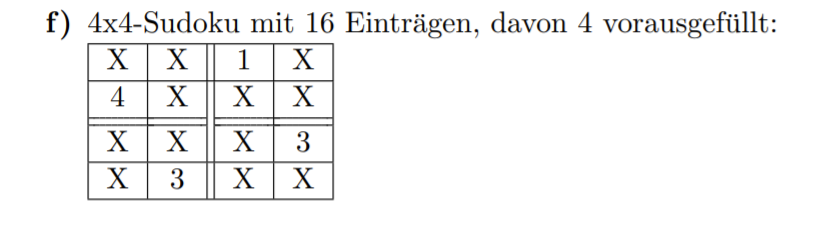

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
import copy
import progressbar
import os
import os.path
from scipy.optimize import minimize
import matplotlib.pylab as plt
import plotly.express as px
import seaborn as sns
import random

#Quantum Annealing
from dwave_qbsolv import QBSolv
import dimod
import neal
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler
import dimod.utilities

#Quantum Gate Model
from qiskit import IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit.aqua.operators import EvolvedOp
from qiskit.opflow import CircuitOp
from qiskit.optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit.optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Operator
from pennylane import qaoa
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

import utils


## Variablen Deklaration:
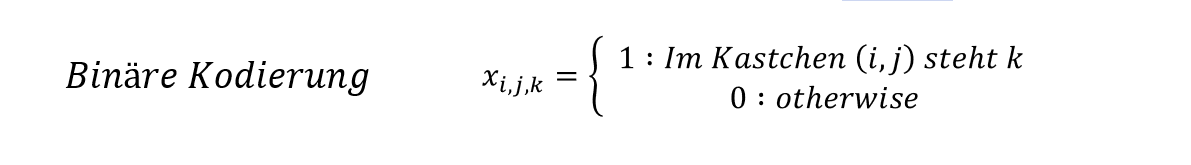

In [53]:
row_num = 4
column_num = 4
k_max = max(row_num, column_num)

num_sub_row = 2
num_sub_column = 2
block_size = 2

In [54]:
#Gewichte für Penalty funktions

alpha = 1
beta = 2
gamma = 2
delta = 1

In [55]:
# known values
known_vars = {}

known_vars[(0,2)] = 0

known_vars[(1,0)] = 3

known_vars[(2,3)] = 2

known_vars[(3,1)] = 2


In [56]:
def get_all_vars(row_num, column_num, k_max):
    alle_vars = []
    for i in range(row_num):
        for j in range(column_num):
            for k in range(k_max):
                alle_vars.append((i,j,k))
    return alle_vars

In [57]:
def get_unbekannte_vars(row_num, column_num, k_max, known_vars):
    var_list = []

    for i in range(row_num):
        for j in range(column_num):
            for k in range(k_max):
                if (i, j) not in known_vars.keys():
                    var_list.append((i,j,k))
    return var_list

In [58]:
# row_num, column_num - matrix size
# num_sub_row, num_sub_column - anzahl von subblocks
def get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars):
    all_vars = get_all_vars(row_num, column_num, k_max)
    var_list = get_unbekannte_vars(row_num, column_num, k_max, known_vars)
    prunned_list = var_list
    all_blocks = get_all_blocks(num_sub_row, num_sub_column)
    
    #prunning rows and columns
    for known_var in known_vars:
        for var in var_list:
            if (var[0] == known_var[0] or var[1] == known_var[1]):
                if (var[2] == known_vars[known_var]):
                    prunned_list.remove(var)
    
    #prunning blocks
    for block in all_blocks:
        variables_in_block = get_vars_in_block(all_vars, block[0], block[1], block_size)
        for var_1 in variables_in_block:
            for var_2 in variables_in_block:
                if (((var_1[0], var_1[1]) in known_vars) and (var_2 in prunned_list)):
                    if (var_2[2] == known_vars[(var_1[0],var_1[1])]):
                        prunned_list.remove(var_2)
                    
    return prunned_list

In [59]:
def get_all_blocks(num_sub_row, num_sub_column):
    all_blocks = []
    for i in range(num_sub_column):
        for j in range(num_sub_row):
            all_blocks.append((i,j))
    return all_blocks

In [60]:
def get_vars_in_block(all_vars, sub_row, sub_column, block_size):
    variables_in_block = []
    for var in all_vars:
        if(var[0] >= sub_row*block_size and var[0] < (sub_row+1)*block_size and 
            var[1] >= sub_column*block_size and var[1] < (sub_column+1)*block_size):
            variables_in_block.append(var)
    return variables_in_block

In [61]:
all_vars = get_all_vars(row_num, column_num, k_max)
var_list = get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [62]:
prunned_list

[(0, 0, 1),
 (0, 0, 2),
 (0, 1, 1),
 (0, 3, 1),
 (0, 3, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 2, 1),
 (1, 2, 2),
 (1, 3, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 3),
 (2, 2, 1),
 (2, 2, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 2, 1),
 (3, 2, 3),
 (3, 3, 0),
 (3, 3, 1),
 (3, 3, 3)]

In [63]:
p_list = []
appender = []
remember = prunned_list[0]
for tupel in prunned_list:
    if (tupel[0] != remember[0] or tupel[1] != remember[1]):
        remember = tupel
        if (len(appender) > 1):
            for a in appender:
                p_list.append(a)
        else:
            known_vars[(appender[0][0], appender[0][1])] = appender[0][2]
        appender = []
        appender.append(tupel)
    else:
        appender.append(tupel)
        
if (len(appender) > 1):
    for a in appender:
        p_list.append(a)
else:
    known_vars[(appender[0][0], appender[0][1])] = appender[0][2]

In [64]:
len(prunned_list)

24

In [65]:
len(p_list)

22

In [66]:
prunned_list = p_list

-------

# Constraints and Penalty functions

In [67]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### H1 == Nur eine Zahl in jedes Kästchen

In [68]:
def h1_penalty(weight, QUBO, prunned_list):
    for variable in prunned_list:
        i = prunned_list.index(variable)
        QUBO[i][i] += -weight
    
        for variable_2 in prunned_list:
            j = prunned_list.index(variable_2)
            if (variable_2[0] == variable[0] and variable_2[1] == variable[1]):
                if (variable_2[2] > variable[2]):
                    QUBO[i][j] += 2*weight
    return QUBO

In [69]:
QUBO = h1_penalty(alpha, QUBO, prunned_list)

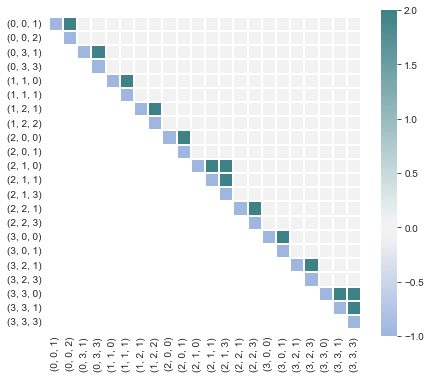

In [70]:
penalty = 'h1'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### H2 == Each column-j cannot have any duplicate number

In [71]:
def h2_penalty(weight, QUBO, prunned_list, all_vars, known_vars):
    #diags
    for variable in prunned_list:
        i = prunned_list.index(variable)
        QUBO[i][i] += -weight
    
    for first_var in all_vars:
        for second_var in all_vars:
            
            #wenn mind einer von ihnen unbekannt ist
            if ((not (first_var[0], first_var[1]) in known_vars) or (not (second_var[0],second_var[1]) in known_vars)):
                #und zwei indizies gleich
                if (first_var[1] == second_var[1] and first_var[2] == second_var[2]):
                    #summierte index j>i
                    if (first_var[0] > second_var[0]):
                        #erste unbekannt 
                        if ((not (first_var[0],first_var[1]) in known_vars) and ((second_var[0],second_var[1]) in known_vars)):
                            if (first_var in prunned_list):
                                i = prunned_list.index(first_var)
                                x_known = (second_var[2] == known_vars[(second_var[0], second_var[1])])
                                QUBO[i][i] += weight*(2*x_known)
                            
                        #zweite unbekannt 
                        if (((first_var[0],first_var[1]) in known_vars) and (not (second_var[0],second_var[1]) in known_vars)):
                            if (second_var in prunned_list):
                                i = prunned_list.index(second_var)
                                x_known = (first_var[2] == known_vars[(first_var[0],first_var[1])])
                                QUBO[i][i] += weight*(2*x_known)
                            
                        #erste und zweite unbekannt 
                        if ((not (first_var[0],first_var[1]) in known_vars) and (not (second_var[0],second_var[1]) in known_vars)):
                            if (second_var in prunned_list and first_var in prunned_list):
                                j = prunned_list.index(first_var)
                                i = prunned_list.index(second_var)
                                QUBO[i][j] += 2*weight
    return QUBO

In [72]:
QUBO = h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)

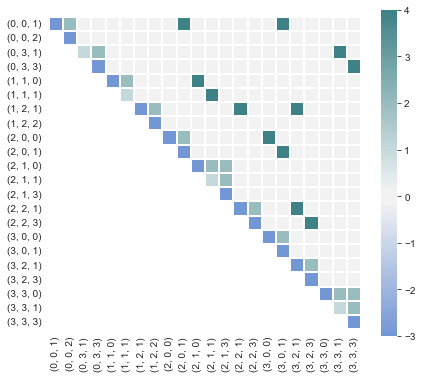

In [73]:
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### H3 == Each row-i cannot have any duplicate number

In [74]:
def h3_penalty(weight, QUBO, prunned_list, all_vars, known_vars):
    for variable in prunned_list:
        i = prunned_list.index(variable)
        QUBO[i][i] += -weight
    
    for first_var in all_vars:
        for second_var in all_vars:
            #wenn mind einer von ihnen unbekannt ist
            if ((not (first_var[0],first_var[1]) in known_vars) or (not (second_var[0],second_var[1]) in known_vars)):
                #zwei indizies gleich
                if (first_var[0] == second_var[0] and first_var[2] == second_var[2]):
                    if (first_var[1] > second_var[1]):
                        
                        if ((not (first_var[0],first_var[1]) in known_vars) and ((second_var[0],second_var[1]) in known_vars)):
                            if (first_var in prunned_list):
                                i = prunned_list.index(first_var)
                                x_known = (second_var[2] == known_vars[(second_var[0],second_var[1])])
                                QUBO[i][i] += weight*(2*x_known)
                                #print(str(first_var) + '---' + str(second_var))
                    
                        if (((first_var[0],first_var[1]) in known_vars) and (not (second_var[0],second_var[1]) in known_vars)):
                            if (second_var in prunned_list):
                                i = prunned_list.index(second_var)
                                x_known = (first_var[2] == known_vars[(first_var[0],first_var[1])])
                                QUBO[i][i] += weight*(2*x_known)
                            
                        if ((not (first_var[0],first_var[1]) in known_vars) and (not (second_var[0],second_var[1]) in known_vars)):
                            if (second_var in prunned_list and first_var in prunned_list):
                                j = prunned_list.index(first_var)
                                i = prunned_list.index(second_var)
                        
                                QUBO[i][j] += 2*weight
    return QUBO

In [75]:
QUBO = h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)

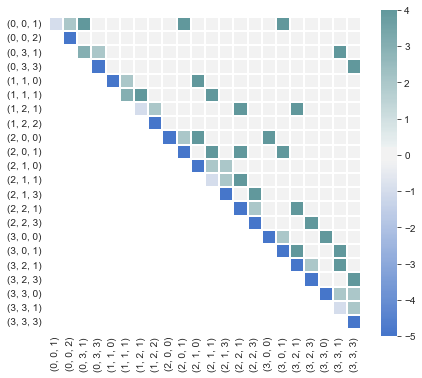

In [76]:
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### H4 ==  Each of the nine 2x2 subgrids cannot have any duplicate number

In [77]:
all_blocks = get_all_blocks(num_sub_row, num_sub_column)

In [78]:
def h4_penalty(weight, QUBO, prunned_list, all_vars, known_vars,all_blocks):
    for block in all_blocks:
        variables_in_block = get_vars_in_block(all_vars, block[0], block[1], block_size)
        
        for var_1 in variables_in_block:
            #lin term
            if (var_1 in prunned_list):
                i = prunned_list.index(var_1)
                QUBO[i][i] += -weight
            
            #
            for var_2 in variables_in_block:
                if (variables_in_block.index(var_2)>variables_in_block.index(var_1)):
                    if (var_1[2] == var_2[2]):
                        #print(str(var_1) + '---' + str(var_2))
                        
                        #wenn mind einer var in den unbekannt ist
                        if ((not (var_1[0], var_1[1]) in known_vars) or (not (var_2[0], var_2[1]) in known_vars)):
                            
                            #zweite bekannt
                            if ((not (var_1[0],var_1[1]) in known_vars) and ((var_2[0],var_2[1]) in known_vars)):
                                if (var_1 in prunned_list):
                                    i = prunned_list.index(var_1)
                                    x_known = (var_2[2] == known_vars[(var_2[0], var_2[1])])
                                    #print(delta*(2*x_known))
                                    QUBO[i][i] += weight*(2*x_known)
                            
                            #erste bekannt
                            if (((var_1[0],var_1[1]) in known_vars) and (not (var_2[0],var_2[1]) in known_vars)):
                                if (var_2 in prunned_list):
                                    i = prunned_list.index(var_2)
                                    x_known = (var_1[2] == known_vars[(var_1[0],var_1[1])])
                                    QUBO[i][i] += weight*(2*x_known)
                                    #print(QUBO[0][0])
                                    #print(str(var_1) + '---' + str(var_2))
                                
                            #beide unbekannt
                            if ((not (var_1[0],var_1[1]) in known_vars) and (not (var_2[0],var_2[1]) in known_vars)):
                                if (var_1 in prunned_list and var_2 in prunned_list):
                                    j = prunned_list.index(var_2)
                                    i = prunned_list.index(var_1)
                                    QUBO[i][j] += 2*weight
    return QUBO
                

In [79]:
QUBO = h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars,all_blocks)

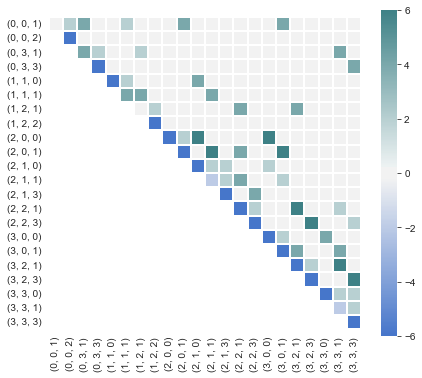

In [80]:
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

In [81]:
def visualize_solution(row_num, column_num, prunned_list, known_vars, result):
    for i, var in enumerate(prunned_list):
        if (int(result[i])==1):
            known_vars[(var[0],var[1])] = var[2]
    sudoku = np.zeros((row_num, column_num))
    for i in range(row_num):
        for j in range(column_num):
            sudoku[i][j] = known_vars[(i,j)] + 1
    return np.asmatrix(sudoku)

In [82]:
def matrix_to_dictionary(QUBO):
    n = len(QUBO)

    ## convert QUBO to dictionary 
    qubo_d = {}
    x1 = 0
    while x1 < n:
        x2 = x1
        while x2 < n:
            qubo_d[(x1, x2)] = int(QUBO[x1][x2])
            x2 += 1
        x1 += 1
    return qubo_d

--------

# Lösung mit QBSolve (Simulated Annealing)

In [83]:
qubo_d = matrix_to_dictionary(QUBO)
sampleset = utils.on_QBsolve(qubo_d)

In [84]:
for sample in sampleset:
    result = [y for _, y in sample.items()]
    solution = visualize_solution(row_num, column_num, prunned_list, known_vars, result)
    print(solution)
    print()

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [2. 4. 4. 3.]
 [2. 3. 2. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [2. 4. 4. 3.]
 [1. 3. 2. 1.]]



-----

# Lösung mit DWave (DWave Advantage)

In [89]:
sampleset = utils.on_DWave(QUBO, 100)

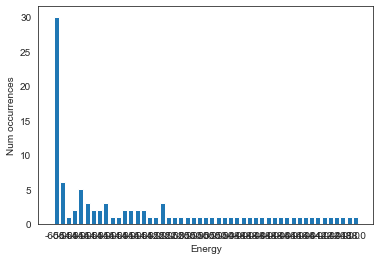

In [90]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [33]:
for sample in sampleset:
    result = [y for _, y in sample.items()]
    solution = visualize_solution(row_num, column_num, prunned_list, known_vars, result)
    print(solution)
    print()

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [2. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 2. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 2.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 4. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 2. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 2. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [2. 4. 4. 3.]
 [2. 3. 2. 1.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [2. 4. 4. 3.]
 [2. 3. 4. 2.]]

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 4. 3.]
 [2. 3. 4. 1.]]

[[3. 2. 

----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [41]:
def QUBO_to_QuadraticProgram(QUBO):
    qubo = QuadraticProgram()
            
    ## übersetzen QUBO in Quadratic Program
    N = len(QUBO)
    for i in range(N):
       l='x'+str(i)
       qubo.binary_var(l)

    quad2={}
    for i in range(N):
        li='x'+str(i)
        for j in range(N):
            lj='x'+str(j)
            quad2.update({(li, lj): QUBO[i,j]})
    qubo.minimize(quadratic=quad2)
    return qubo

In [42]:
quadr_program = QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ 4 x0*x1 + 8 x0*x2 + 4 x0*x5 + 8 x0*x9 + 8 x0*x16 - 12 x1^2 + 8 x2^2
      + 4 x2*x3 + 4 x2*x6 + 8 x2*x20 - 12 x3^2 + 8 x3*x21 - 12 x4^2 + 4 x4*x5
      + 8 x4*x10 + 8 x5^2 + 8 x5*x6 + 8 x5*x11 + 4 x6*x7 + 8 x6*x13 + 8 x6*x17
      - 12 x7^2 - 12 x8^2 + 4 x8*x9 + 12 x8*x10 + 12 x8*x15 - 12 x9^2
      + 12 x9*x11 + 8 x9*x13 + 12 x9*x16 - 12 x10^2 + 4 x10*x11 + 4 x10*x12
      + 4 x10*x15 - 4 x11^2 + 4 x11*x12 + 8 x11*x13 + 4 x11*x16 - 12 x12^2
      + 8 x12*x14 - 12 x13^2 + 4 x13*x14 + 12 x13*x17 + 4 x13*x20 - 12 x14^2
      + 12 x14*x18 + 4 x14*x21 - 12 x15^2 + 4 x15*x16 + 8 x15*x19 - 12 x16^2
      + 8 x16*x17 + 8 x16*x20 - 12 x17^2 + 4 x17*x18 + 12 x17*x20 - 12 x18^2
      + 12 x18*x21 - 12 x19^2 + 4 x19*x20 + 4 x19*x21 - 4 x20^2 + 4 x20*x21
      - 12 x21^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= 

In [43]:
#convert QP zu Ising
H, offset = quadr_program.to_ising()
# plot diagonal of matrix
#H_matrix = np.real(H.to_matrix())
# plot diagonal of matrix
#opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]

In [44]:
optimizer = COBYLA(maxiter=250)#

qaoa_mes = QAOA(optimizer=optimizer,  
                quantum_instance=Aer.get_backend('qasm_simulator'))
result = qaoa_mes.compute_minimum_eigenvalue(H)
qaoa_mes.get_optimal_circuit()

print('optimal params:      ', result.optimal_parameters)
print('optimal value:       ', result.optimal_value)
#print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))
#result.eigenstate
#probabilities = np.abs(result.eigenstate)**2
#plt.figure(figsize=(12, 5))
#plt.bar(range(2**n), probabilities)
#plt.bar(opt_indices, probabilities[opt_indices], color='g')
#plt.xticks(range(2**n), ['{0:04b}'.format(i) for i in range(2**n)], rotation=90, fontsize=12)
#plt.yticks(fontsize=14)
#plt.show()
#print('('+str(i)+') {0:04b}'.format(i) for i in range(2**n))#, probabilities)
#np.abs(result.eigenstate)**2

optimal params:       {ParameterVectorElement(θ[0]): 6.1402562194175925, ParameterVectorElement(θ[1]): 0.602419986719613}
optimal value:        -25.880859375


In [45]:
# Run quantum algorithm QAOA on qasm simulator
#optimizer = SPSA(maxiter=250)
optimizer = COBYLA(maxiter=250)#

backend = Aer.get_backend('qasm_simulator')

qaoa = QAOA(optimizer=optimizer, quantum_instance=backend)
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(quadr_program)
print(result)

optimal function value: -42.0
optimal value: [0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.]
status: SUCCESS


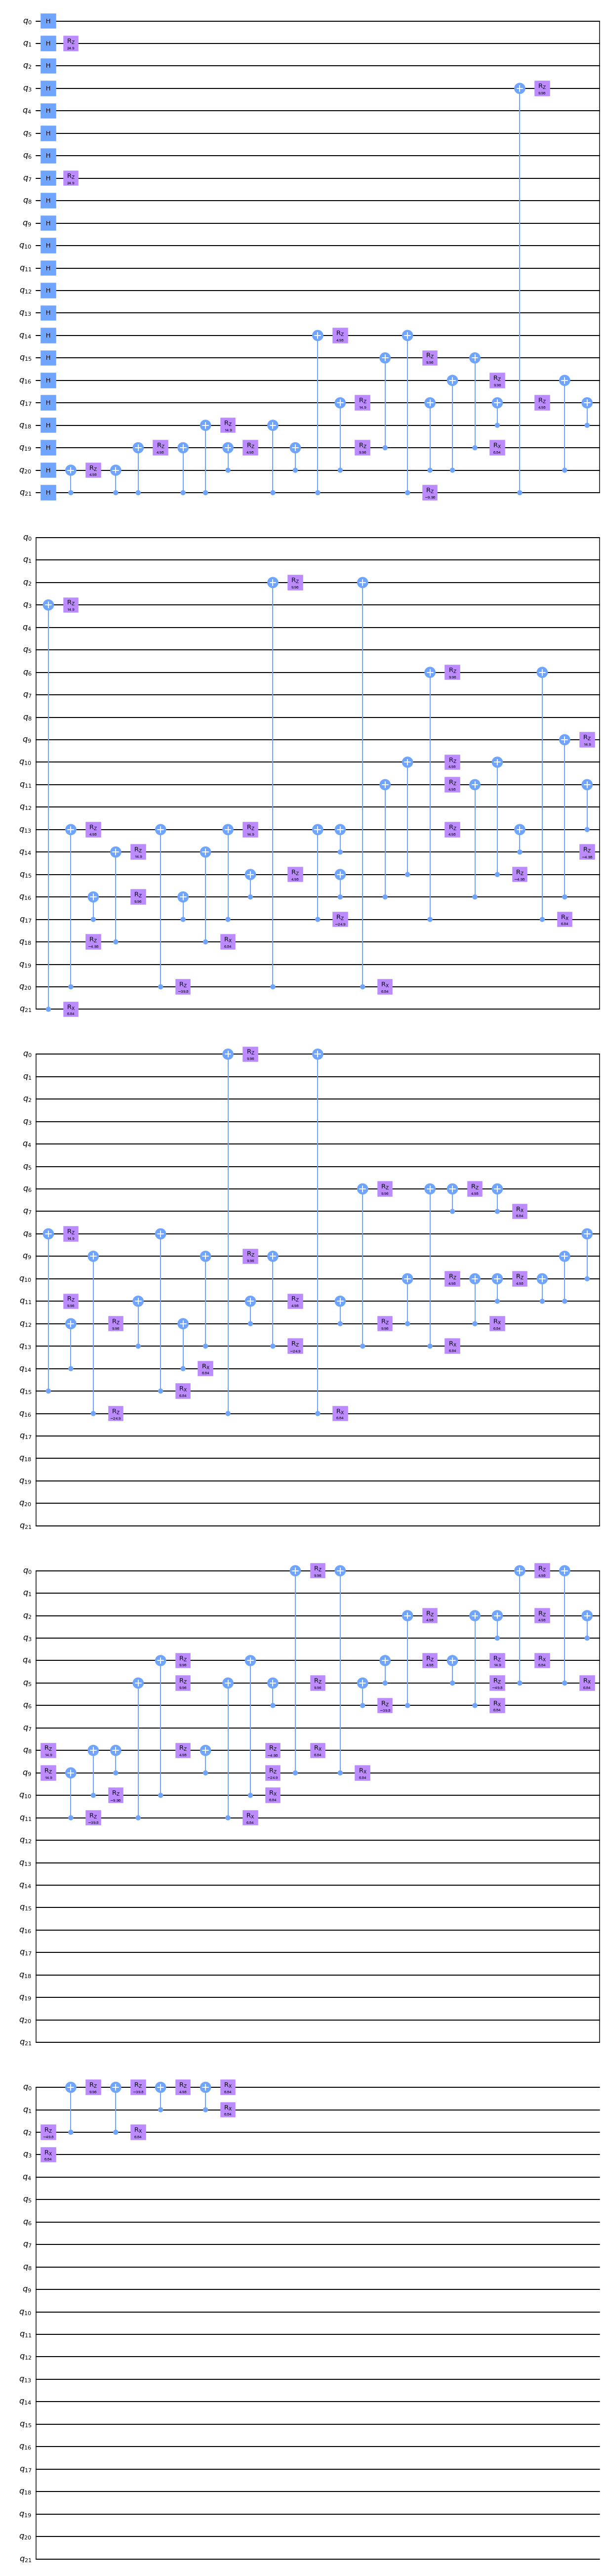

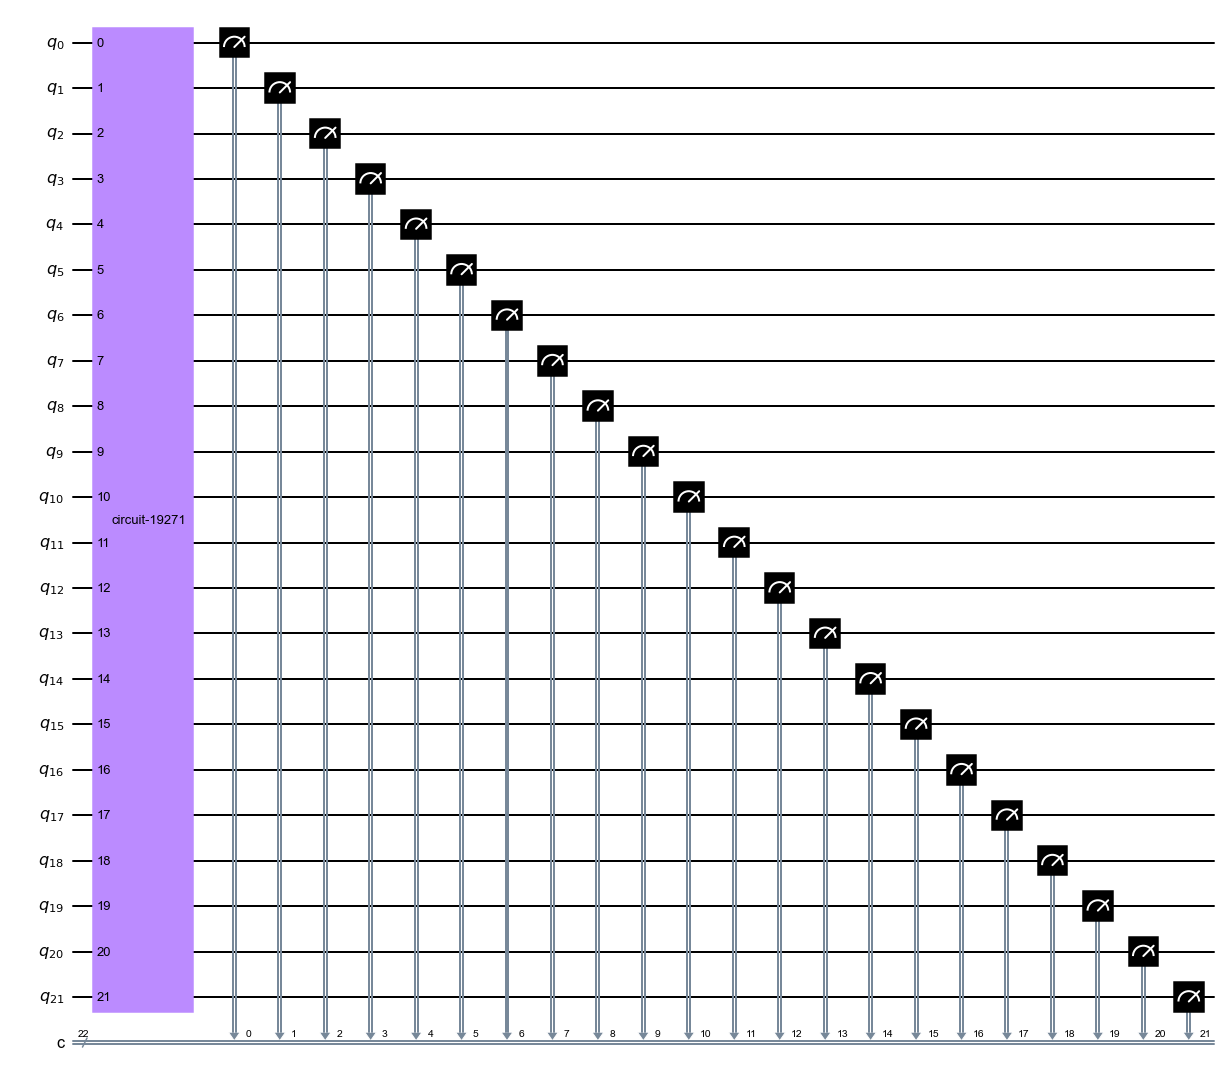

In [46]:
qc = qaoa.get_optimal_circuit()
display(qc.draw('mpl'))
gate = qc.to_gate() 

wires = range(n)

qc_qaoa = QuantumCircuit(n, n)
qc_qaoa.append(gate, wires)
qc_qaoa.measure(wires, wires)
display(qc_qaoa.draw('mpl'))

### Kosten:

In [50]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc_qaoa, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 66
Gate counts: OrderedDict([('u3', 110), ('cx', 88), ('measure', 22)])
Optimization Level 1
Depth: 66
Gate counts: OrderedDict([('u3', 106), ('cx', 88), ('measure', 22)])
Optimization Level 2
Depth: 66
Gate counts: OrderedDict([('u3', 106), ('cx', 88), ('measure', 22)])
Optimization Level 3
Depth: 66
Gate counts: OrderedDict([('u3', 106), ('cx', 88), ('measure', 22)])


In [51]:
trans_qc.count_ops()['u3'] + 10 * trans_qc.count_ops()['cx']

986

In [62]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)

ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))
#new_circuit.draw(output='mpl')

OrderedDict([('u3', 124), ('cx', 104)])
Cost: 1164


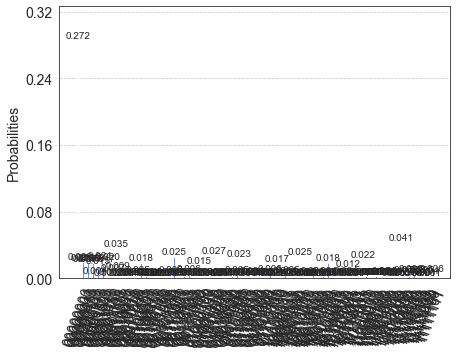

In [153]:
shots = 1000
job = execute(qc_qaoa, backend, shots = shots)
plot_histogram(job.result().get_counts(qc_qaoa))

In [154]:
result = job.result().get_counts(qc_qaoa).most_frequent()

In [156]:
solution = visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]
